# 08 - XGBoost model

Goals:
- Load the data `features_match_long_elo_22_23.csv` 
- Choose X (features) and Y (target = result H/D/A)
- Split train/test by time order
- Features standardization
- Train XG Boost
- Calculate : Log Loss, Brier Score, Accuracy
- plot the calibration curves

In [17]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, brier_score_loss
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

import xgboost as xgb  # XGBoost library

pd.set_option("display.max_columns", 50)

In [18]:
# Path to the long-format dataset already enriched with Elo features
df = pd.read_csv("../data/processed/features_matches_long_elo_22_23.csv")

print("Long + Elo features shape:", df.shape)
df.head()

Long + Elo features shape: (760, 33)


,match_id,season,date,team,opponent,is_home,result,goals_for,goals_against,points,prob_book_home,prob_book_draw,prob_book_away,goal_diff,xg_diff,xg_for,xg_against,rolling_xg_for_5,rolling_xg_against_5,rolling_xg_diff_5,rolling_points_5,rolling_home_points_5,rolling_away_points_5,strength_points_5,rolling_goal_diff_5,rolling_home_goal_diff_5,rolling_away_goal_diff_5,elo_home_before,elo_away_before,elo_diff_home,elo_team_before,elo_opponent_before,elo_diff_for_team
0,1,2022-2023,2022-08-05,Arsenal,Crystal Palace,0,A,2,0,3,0.218795,0.266625,0.514581,2,-0.2,1.0,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.000000,1500.000000,0.000000,1500.000000,1500.000000,0.000000
1,16,2022-2023,2022-08-13,Arsenal,Leicester City,1,H,4,2,3,0.616659,0.222323,0.161018,2,2.2,2.7,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1515.328421,1497.171579,18.156841,1515.328421,1497.171579,18.156841
2,23,2022-2023,2022-08-20,Arsenal,Bournemouth,0,A,3,0,3,0.121887,0.204302,0.673812,3,1.0,1.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500.192375,1524.387995,-24.195620,1524.387995,1500.192375,24.195620
3,35,2022-2023,2022-08-27,Arsenal,Fulham,1,H,2,1,3,0.730850,0.167736,0.101414,1,1.8,2.6,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1538.878630,1509.853905,29.024725,1538.878630,1509.853905,29.024725
4,49,2022-2023,2022-08-31,Arsenal,Aston Villa,1,H,2,1,3,0.647946,0.209616,0.142438,1,2.0,2.4,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1547.580022,1473.449924,74.130098,1547.580022,1473.449924,74.130098


In [19]:
target_col = "result"

feature_cols = [
    "is_home",
    "rolling_xg_for_5",
    "rolling_xg_against_5",
    "rolling_xg_diff_5",
    "rolling_points_5",
    "strength_points_5",
    "elo_home_before",
    "elo_away_before",
    "elo_diff_home"
]

# Check NaNs before dropping
print("NaN per column BEFORE drop:")
print(df[feature_cols + [target_col]].isna().sum())

# Drop rows with missing values in features or target
df_clean = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

print("\nShape AFTER drop:", df_clean.shape)
print("NaN per column AFTER drop:")
print(df_clean[feature_cols + [target_col]].isna().sum())

# Ensure date is datetime and sort chronologically
df_clean["date"] = pd.to_datetime(df_clean["date"])
df_clean = df_clean.sort_values("date").reset_index(drop=True)

X = df_clean[feature_cols].copy()
y = df_clean[target_col].copy()

print("\nX shape:", X.shape)
print("y shape:", y.shape)

NaN per column BEFORE drop:
is_home                   0
rolling_xg_for_5        100
rolling_xg_against_5    100
rolling_xg_diff_5       100
rolling_points_5        100
strength_points_5       200
elo_home_before           0
elo_away_before           0
elo_diff_home             0
result                    0
dtype: int64

Shape AFTER drop: (560, 33)
NaN per column AFTER drop:
is_home                 0
rolling_xg_for_5        0
rolling_xg_against_5    0
rolling_xg_diff_5       0
rolling_points_5        0
strength_points_5       0
elo_home_before         0
elo_away_before         0
elo_diff_home           0
result                  0
dtype: int64

X shape: (560, 9)
y shape: (560,)


In [25]:
train_ratio = 0.8
train_size = int(train_ratio * len(df_clean))

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes :", X_test.shape, y_test.shape)

print("\nNaN in TRAIN features:")
print(X_train.isna().sum())

print("\nNaN in TEST features:")
print(X_test.isna().sum())

Train shapes: (448, 9) (448,)
Test shapes : (112, 9) (112,)

NaN in TRAIN features:
is_home                 0
rolling_xg_for_5        0
rolling_xg_against_5    0
rolling_xg_diff_5       0
rolling_points_5        0
strength_points_5       0
elo_home_before         0
elo_away_before         0
elo_diff_home           0
dtype: int64

NaN in TEST features:
is_home                 0
rolling_xg_for_5        0
rolling_xg_against_5    0
rolling_xg_diff_5       0
rolling_points_5        0
strength_points_5       0
elo_home_before         0
elo_away_before         0
elo_diff_home           0
dtype: int64


In [21]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes:", le.classes_)     # expected ['A', 'D', 'H']
print("First 10 encoded y_train:", y_train_enc[:10])

Classes: ['A' 'D' 'H']
First 10 encoded y_train: [2 1 2 2 0 2 0 2 2 1]


In [22]:
# XGBoost multiclass classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",  # to get class probabilities
    num_class=3,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="mlogloss",      # avoid warning
)

xgb_model.fit(X_train, y_train_enc)
print("XGBoost model trained!")

XGBoost model trained!


In [23]:
# Predicted probabilities and class predictions
y_proba_xgb = xgb_model.predict_proba(X_test)
y_pred_xgb  = xgb_model.predict(X_test)

print("Predicted probabilities shape:", y_proba_xgb.shape)
print("Sample predictions:", y_pred_xgb[:10])
print("Sample true labels:", y_test_enc[:10])

# Accuracy
acc_xgb = accuracy_score(y_test_enc, y_pred_xgb)
print("\nAccuracy on test set (XGBoost):", round(acc_xgb, 3))

# Log loss
ll_xgb = log_loss(y_test_enc, y_proba_xgb)
print("Log loss on test set (XGBoost):", round(ll_xgb, 4))

# Brier score per class
brier_scores_xgb = []
for class_idx, class_label in enumerate(le.classes_):
    y_true_binary = (y_test_enc == class_idx).astype(int)
    y_prob_class  = y_proba_xgb[:, class_idx]
    brier = brier_score_loss(y_true_binary, y_prob_class)
    brier_scores_xgb.append(brier)
    print(f"Brier score for class {class_label} (XGB): {brier:.4f}")

mean_brier_xgb = float(np.mean(brier_scores_xgb))
print("Mean Brier score (XGB):", round(mean_brier_xgb, 4))


Predicted probabilities shape: (112, 3)
Sample predictions: [2 2 2 2 2 2 1 2 0 1]
Sample true labels: [2 2 2 2 2 2 0 2 2 0]

Accuracy on test set (XGBoost): 0.527
Log loss on test set (XGBoost): 1.2208
Brier score for class A (XGB): 0.2146
Brier score for class D (XGB): 0.1953
Brier score for class H (XGB): 0.2388
Mean Brier score (XGB): 0.2162


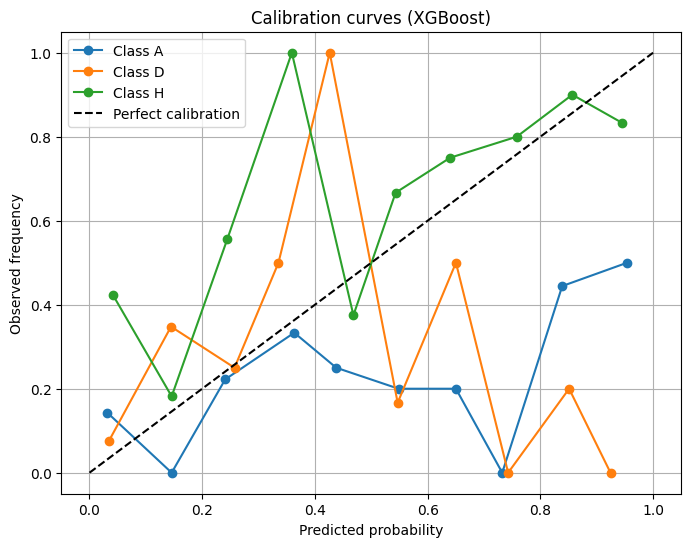

In [24]:
plt.figure(figsize=(8, 6))

for class_idx, class_label in enumerate(le.classes_):
    y_true_binary = (y_test_enc == class_idx).astype(int)
    y_prob_class  = y_proba_xgb[:, class_idx]

    true_frac, pred_mean = calibration_curve(
        y_true_binary,
        y_prob_class,
        n_bins=10,
        strategy="uniform",
    )

    plt.plot(
        pred_mean,
        true_frac,
        marker="o",
        label=f"Class {class_label}",
    )

plt.plot([0, 1], [0, 1], "--", color="black", label="Perfect calibration")

plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curves (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()